In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib
from functools import partial
import optax

import set_rcParams

In [2]:

def loss(lambda_est, lambda_star, mu=0, sigma=1, lower_bound=0.):
    expectation_part =  mu**2 * jnp.abs(1 / (1 - lambda_est)  - 1 / (1 - lambda_star)) ** 2
    variance_part = sigma**2 * (1 / (1 - jnp.abs(lambda_est**2)) \
                                + 1 / (1 - jnp.abs(lambda_star)**2) \
                                - (2 / (1 - lambda_est * jnp.conj(lambda_star))).real)
    l = 0.5 * (expectation_part + variance_part)
    return jnp.clip(l, lower_bound, None)

def dh_dlamb(rho, lamb):
    return ((1 + lamb ** 2) * (1 - lamb ** 2 * rho **2 ) + 2 * (1 - lamb ** 2) * lamb * rho) / ((1 - lamb**2) ** 3 * (1 - lamb * rho) ** 2)

def h2(rho, lamb):
    return (1 + rho * lamb) / (1 - lamb * rho) / (1 - lamb ** 2)

CUDA backend failed to initialize: jaxlib/cuda/versions_helpers.cc:98: operation cuInit(0) failed: CUDA_ERROR_NO_DEVICE (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


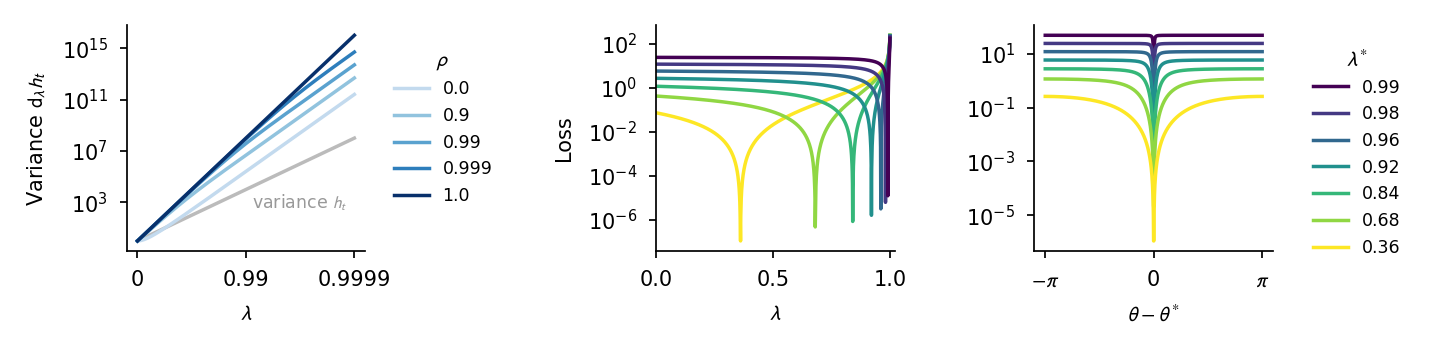

In [3]:
cmap = plt.get_cmap("viridis")
# YlGnBu_r + 0.4 vmax
# YlOrRd_r + 0.4 vmax

fig, ax = plt.subplots(ncols=5, figsize=(5.9, 1.5), gridspec_kw={'width_ratios': [5, 0.25, 5, 5, 0.25]})

lambda_stars = 1 - jnp.array([0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64])
norm = matplotlib.colors.LogNorm(vmin=1-lambda_stars.max(), vmax=1-lambda_stars.min())
for lambda_s in lambda_stars[::-1]:
    lambda_est = jnp.linspace(0, 1, 1000)
    losses = jax.vmap(lambda le: loss(le, lambda_s))(lambda_est)
    ax[2].plot(lambda_est, losses, c=cmap(norm(1-lambda_s)))
ax[2].set_xlabel("$\lambda$")
ax[2].set_ylabel("Loss")
ax[2].set_xlim(0, 1.02)
ax[2].set_yscale("log")

thetas = jnp.linspace(-jnp.pi, jnp.pi, 1000, dtype=jnp.float64)
for lambda_star in lambda_stars:
    loss_ = lambda theta: loss(jnp.exp(1j * theta) * jnp.abs(lambda_star), lambda_star, mu=0, sigma=1)
    ax[3].plot(thetas, loss_(thetas), color=cmap(norm(1 - lambda_star)), label=f"{lambda_star:.2f}")
ax[3].set_xlabel(r"$\theta - \theta^*$")
ax[3].set_yscale("log")
ax[3].set_xticks([-jnp.pi, 0, jnp.pi])
ax[3].set_xticklabels([r"$-\pi$", r"0", r"$\pi$"])


h, l = ax[3].get_legend_handles_labels()
ax[4].legend(h, l, borderaxespad=1, edgecolor="white", fontsize=5, title="$\lambda^*$", framealpha=1)
ax[4].axis("off")


cmap = plt.get_cmap("Blues_r")
rhos = jnp.array([0, 0.9, 0.99, 0.999, 1])
lamb = 1 - jnp.power(10, jnp.linspace(-4, -0., 1000))
norm = matplotlib.colors.Normalize(vmin=jnp.log(1-rhos + 1e-5).min(), vmax=jnp.log(1-rhos + 1e-5).max()+4)
for rho in rhos:
    ax[0].plot(-jnp.log10(1 - lamb), dh_dlamb(rho, lamb), label=f"{rho}", color=cmap(norm(jnp.log(1-rho + 1e-5))))
ax[0].plot(-jnp.log10(1 - lamb), jnp.abs(h2(1, lamb)), color="#BBBBBB", zorder=-1)
ax[0].text(3, 6000, r"variance $h_t$", ha="center", va="top", fontsize=5, color="#999999")
ax[0].set_xlabel("$\\lambda$")
ax[0].set_ylabel(r"Variance $\mathrm{d}_\lambda h_t$")
ax[0].set_yscale("log")
# set x ticks to 0, 0.99, 0.9999
ax[0].set_xticks([0, 2, 4])
ax[0].set_xticklabels([0, 0.99, 0.9999])
ax[0].minorticks_off()

h, l = ax[0].get_legend_handles_labels()
ax[1].legend(h, l, borderaxespad=1, edgecolor="white", fontsize=5, title=r"$\rho$", framealpha=1)
ax[1].axis("off")

plt.tight_layout(w_pad=0.1)
plt.savefig("raw/RNNs_figure1_raw.pdf", bbox_inches="tight", dpi=250)

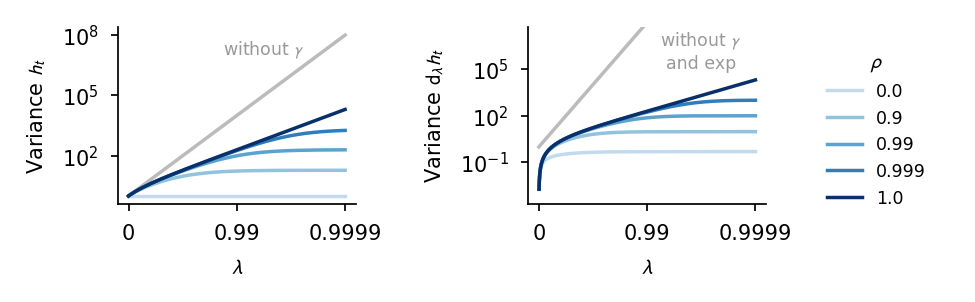

In [7]:
# Plot normalized h_t and d_lambda h_t

fig, ax = plt.subplots(ncols=3, figsize=(4, 1.3), gridspec_kw={'width_ratios': [5, 5, 0.25]})

def dlambda_dnu(lamb):
    nu = jnp.log(-jnp.log(lamb))
    param = lambda x: jnp.exp(-jnp.exp(x))
    return jax.vmap(jax.grad(param))(nu)

cmap = plt.get_cmap("Blues_r")
rhos = jnp.array([0, 0.9, 0.99, 0.999, 1])
lamb = 1 - jnp.power(10, jnp.linspace(-4, -0., 1000))
norm = matplotlib.colors.Normalize(vmin=jnp.log(1-rhos + 1e-5).min(), vmax=jnp.log(1-rhos + 1e-5).max()+4)
for rho in rhos:
    ax[0].plot(-jnp.log10(1 - lamb), h2(rho, lamb) * (1 - lamb**2), label=f"{rho}", color=cmap(norm(jnp.log(1-rho + 1e-5))))
    ax[1].plot(-jnp.log10(1 - lamb), dh_dlamb(rho, lamb) * (1 - lamb**2) * dlambda_dnu(lamb)**2, label=f"{rho}", color=cmap(norm(jnp.log(1-rho + 1e-5))))
ax[0].plot(-jnp.log10(1 - lamb), jnp.abs(h2(1, lamb)), color="#BBBBBB", zorder=-1)
ax[1].plot(-jnp.log10(1 - lamb), dh_dlamb(rho, lamb), color="#BBBBBB", zorder=-1)
ax[0].text(2.5, 6e7, r"without $\gamma$", ha="center", va="top", fontsize=5, color="#999999")
ax[1].text(3, 3e7, r"without $\gamma$" + "\n" + r"and exp", ha="center", va="top", fontsize=5, color="#999999")
ax[0].set_xlabel("$\\lambda$")
ax[1].set_xlabel("$\\lambda$")
ax[0].set_ylabel(r"Variance $h_t$")
ax[1].set_ylabel(r"Variance $\mathrm{d}_\lambda h_t$")
ax[0].set_yscale("log")
ax[1].set_yscale("log")
# set x ticks to 0, 0.99, 0.9999
ax[0].set_xticks([0, 2, 4])
ax[0].set_xticklabels([0, 0.99, 0.9999])
ax[1].set_xticks([0, 2, 4])
ax[1].set_xticklabels([0, 0.99, 0.9999])
ax[1].set_ylim(None, 5e7)
ax[0].minorticks_off()

h, l = ax[1].get_legend_handles_labels()
ax[2].legend(h, l, borderaxespad=1, edgecolor="white", fontsize=5, title=r"$\rho$", framealpha=1)
ax[2].axis("off")

plt.tight_layout()

## Effect of normalization and parametrization

In [8]:
def exp_parametrization(x, y=-1e8):
    return jnp.exp(-jnp.exp(x)) * jnp.exp(1j * jnp.exp(y))

def tanh_parametrization(x, y=0):
    nu = jnp.tanh(x)
    return nu * jnp.exp(1j * (1 - nu**2) / nu / jnp.sqrt(1 + nu**2) * y)

def gamma_loss(lambda_est, lambda_star):
    gamma = lambda x: jnp.sqrt(1 - jnp.abs(x)**2)
    l = (gamma(lambda_est)**2 / (1 - jnp.abs(lambda_est)**2) \
                                + gamma(lambda_star)**2 / (1 - jnp.abs(lambda_star)**2) \
                                - (2 * gamma(lambda_est) * gamma(lambda_star) / (1 - lambda_est * jnp.conj(lambda_star))).real)
    return 0.5 * l

def gamma_hessian_at_opt(lambda_star, param):
    loss_fn = lambda est: gamma_loss(param(est), param(lambda_star))
    hessian = jax.hessian(loss_fn)
    return hessian(lambda_star)


def visualize_loss(fig, ax, lambda_stars, nu_ests, theta_ests, parametrization_name, y_lim_hessian=None, label=False):
    # Loss
    if parametrization_name == "exp":
        parametrization = exp_parametrization
    elif parametrization_name == "normal":
        def parametrization(x, y=0):
            return x * jnp.exp(1j * y)
    elif parametrization_name == "tanh":
        parametrization = tanh_parametrization
    else:
        raise ValueError(f"Unknown parametrization {parametrization_name}")

    # Color map
    norm = matplotlib.colors.LogNorm(vmin=1-lambda_stars.max(), vmax=1-lambda_stars.min())

    # Plot
    for lambda_star in lambda_stars[::-1]:

        # First set of losses: lambda = nu
        loss_fn = lambda est, star: gamma_loss(parametrization(est), star)
        hessian_ = jax.hessian(loss_fn, argnums=0)
        hessian = jax.vmap(lambda x: hessian_(x, lambda_star))
        ax[0].plot(nu_ests, loss_fn(nu_ests, lambda_star), color=cmap(norm(1 - lambda_star)))
        ax[0].set_ylabel("Loss")
        ax[1].plot(nu_ests, hessian(nu_ests), color=cmap(norm(1 - lambda_star)))

    values = lambda_stars
    if parametrization_name == "tanh":
        values = values[::-1]
    for lambda_star in values:
        # Second loss: lambda = l* exp(i theta)
        if parametrization_name == "exp":
            inv_param_star = jnp.log(-jnp.log(lambda_star))
        elif parametrization_name == "tanh":
            inv_param_star = jnp.arctanh(jnp.abs(lambda_star))
        else:
            inv_param_star = lambda_star
        loss_fn = lambda est: gamma_loss(parametrization(inv_param_star, est * jnp.pi), lambda_star * jnp.exp(1j * jnp.pi / 100))
        hessian_ = jax.hessian(loss_fn, argnums=0)
        hessian = jax.vmap(lambda x: hessian_(x))
        if parametrization in ["normal", "tanh"]:
            theta_est_for_loss = theta_ests + 1 / 100
        else:
            theta_est_for_loss = theta_ests
        ax[2].plot(theta_ests, loss_fn(theta_est_for_loss), color=cmap(norm(1 - lambda_star)))
        ax[2].set_ylabel("Loss")
        if label:
            ax[3].plot(theta_ests, hessian(theta_est_for_loss), color=cmap(norm(1 - lambda_star)),  label=f"{lambda_star:.2f}")
        else:
            ax[3].plot(theta_ests, hessian(theta_est_for_loss), color=cmap(norm(1 - lambda_star)))
    
    
    if y_lim_hessian is not None:
        ax[1].set_ylim(y_lim_hessian)
    ax[0].set_yscale("log")
    ax[1].set_yscale("log")
    ax[2].set_yscale("log")
    ax[3].set_yscale("log")
    ax[0].minorticks_off()
    ax[1].minorticks_off()
    ax[2].minorticks_off()
    ax[3].minorticks_off()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


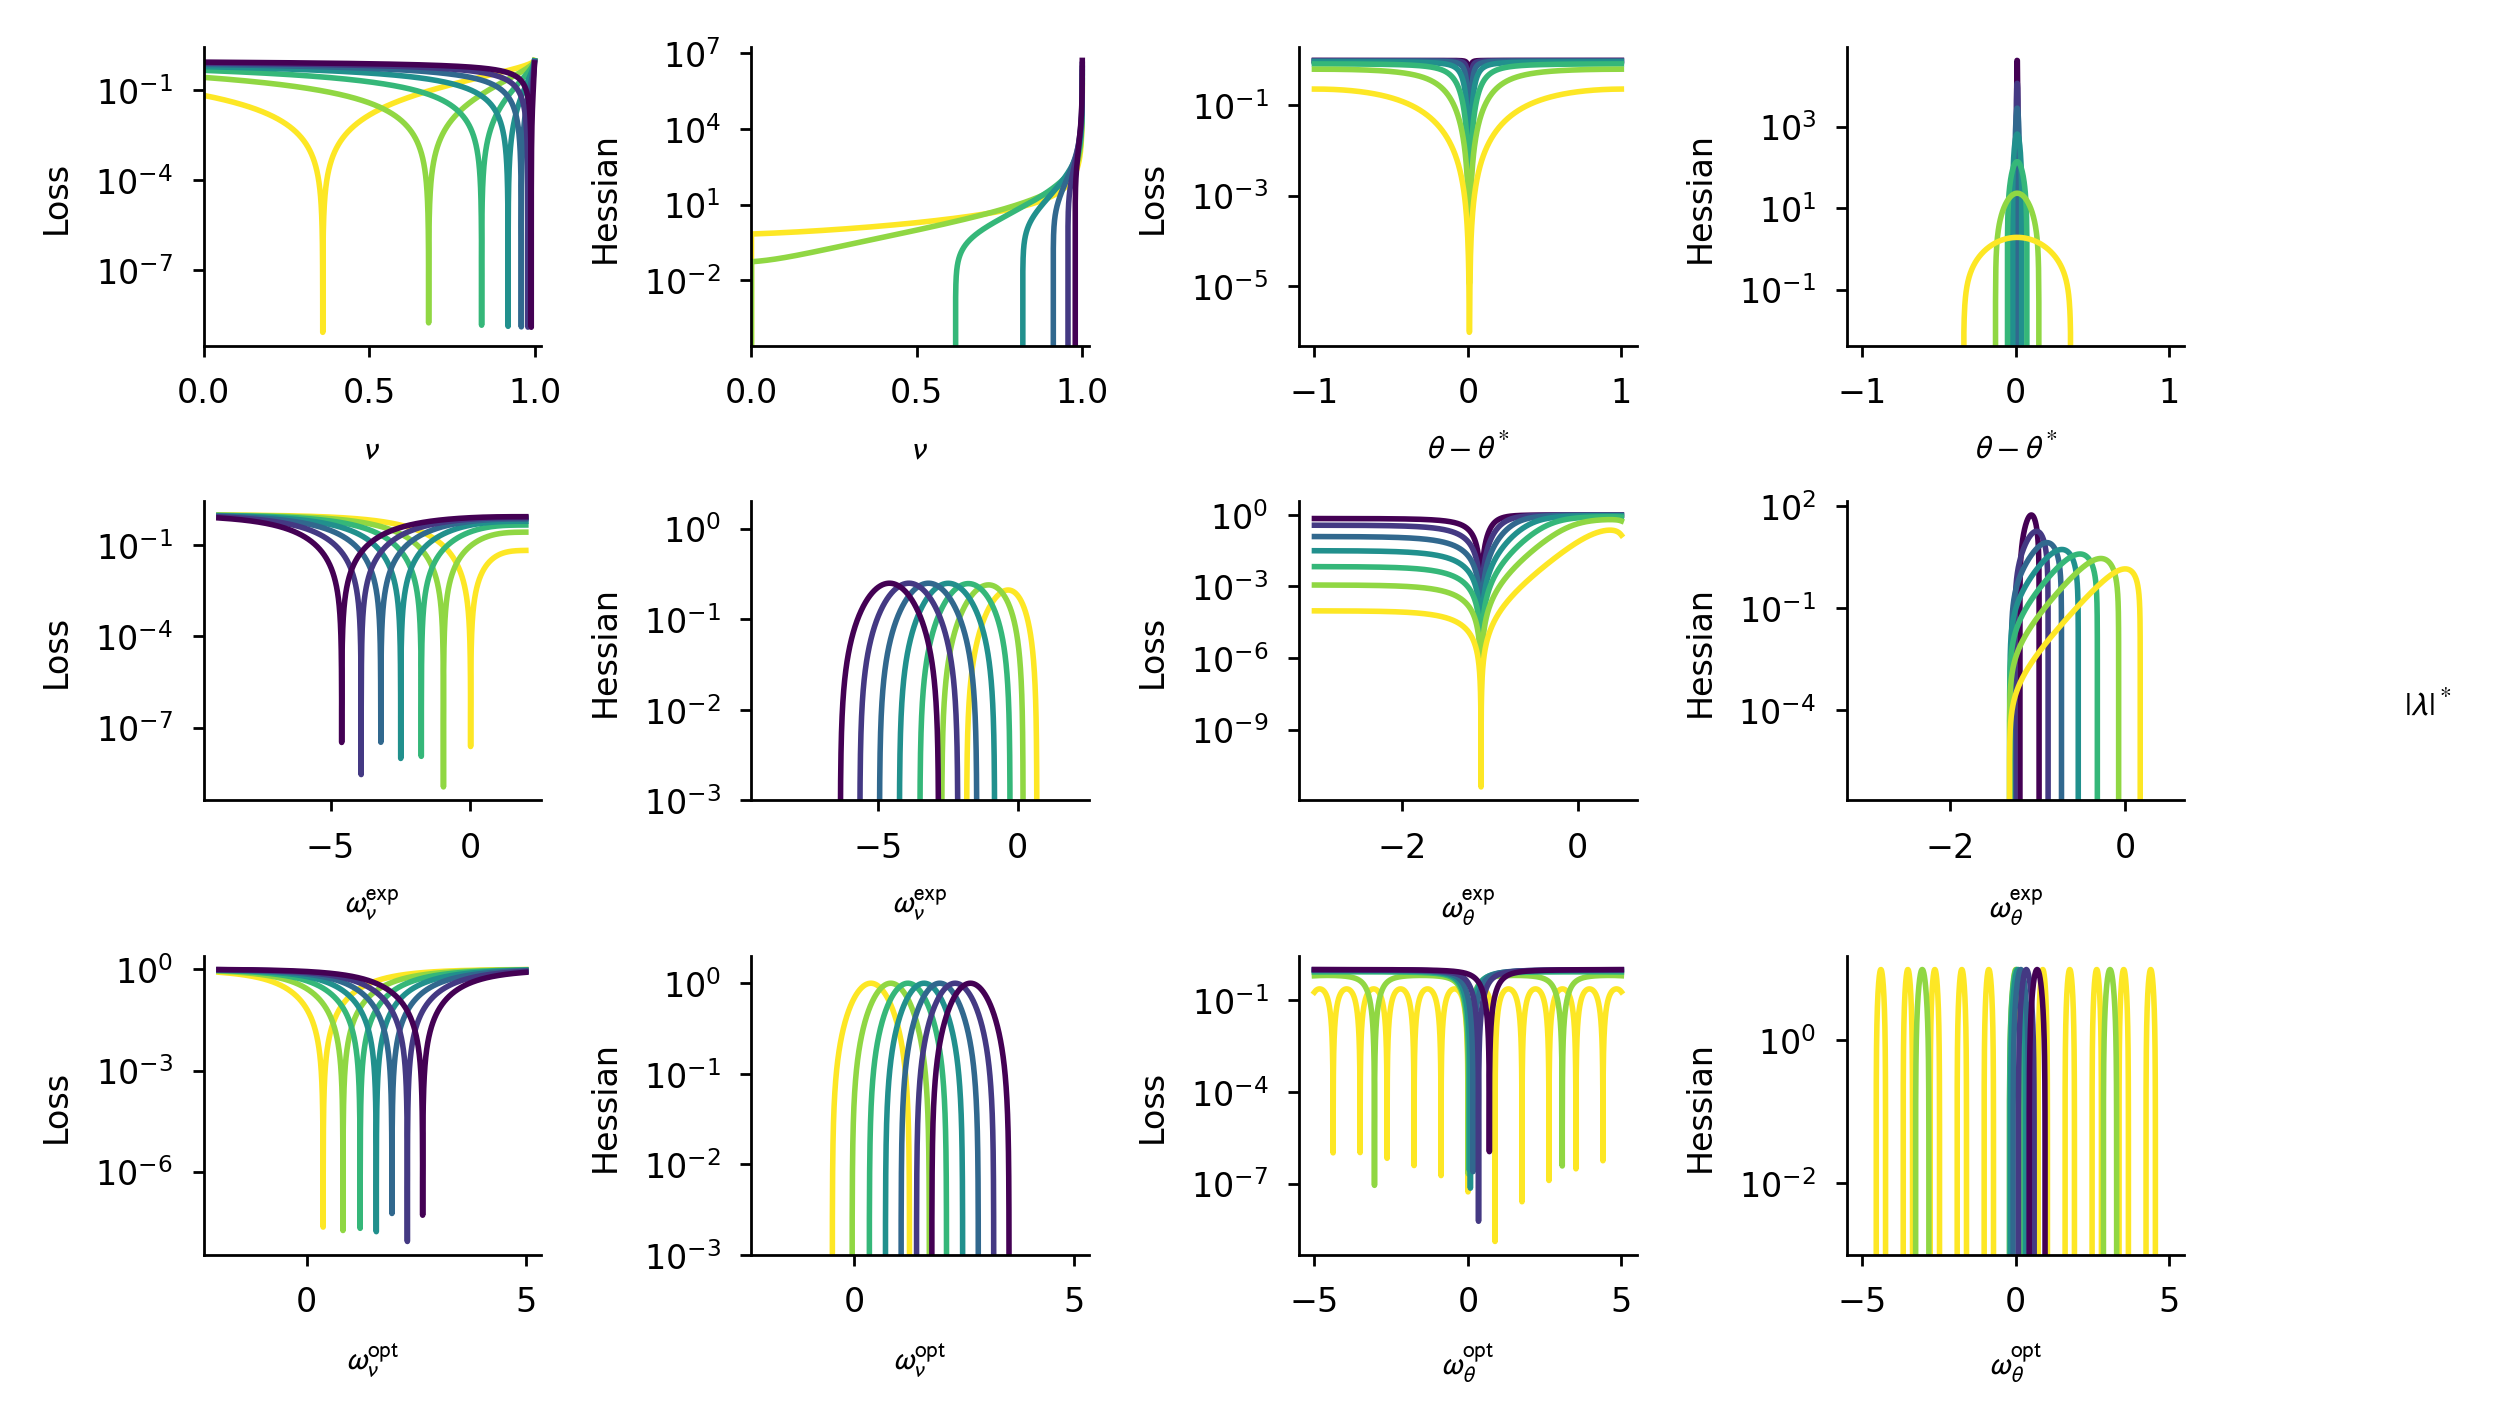

In [9]:
cmap = plt.get_cmap("viridis")

lambda_stars = (1 - jnp.array([0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64]))

fig, ax = plt.subplots(3, 4, figsize=(5.5, 3.5), dpi=400)
plt.minorticks_off()

visualize_loss(fig, ax[0], lambda_stars, jnp.linspace(0, 1, 10000), jnp.linspace(-1, 1, 1000), "normal")
ax[0][0].set_xlim(0, 1.02)
ax[0][0].set_ylabel("Loss")
ax[0][0].set_xlabel(r"$\nu$")
ax[0][1].set_xlim(0, 1.02)
ax[0][1].set_ylabel("Hessian")
ax[0][1].set_xlabel(r"$\nu$")
ax[0][2].set_ylabel("Loss")
ax[0][2].set_xlabel(r"$\theta - \theta^*$")
ax[0][3].set_ylabel("Hessian")
ax[0][3].set_xlabel(r"$\theta - \theta^*$")


plt.minorticks_off()
visualize_loss(fig, ax[1], lambda_stars, jnp.linspace(-9, 2, 10000), jnp.linspace(-3, jnp.log10(jnp.pi), 10000), "exp", y_lim_hessian=(1e-3, 2e0))
ax[1][0].set_ylabel("Loss")
ax[1][0].set_xlabel(r"$\omega_\nu^\mathrm{exp}$")
ax[1][1].set_ylabel("Hessian")
ax[1][1].set_xlabel(r"$\omega_\nu^\mathrm{exp}$")
ax[1][2].set_ylabel("Loss")
ax[1][2].set_xlabel(r"$\omega_\theta^\mathrm{exp}$")
ax[1][3].set_ylabel("Hessian")
ax[1][3].set_xlabel(r"$\omega_\theta^\mathrm{exp}$")


visualize_loss(fig, ax[2], lambda_stars, jnp.linspace(-2.0001, 5, 10000), jnp.linspace(-5, 5, 10000), "tanh", y_lim_hessian=(1e-3, 2e0))
ax[2][0].set_ylabel("Loss")
ax[2][0].set_xlabel(r"$\omega_\nu^\mathrm{opt}$")
ax[2][1].set_ylabel("Hessian")
ax[2][1].set_xlabel(r"$\omega_\nu^\mathrm{opt}$")
ax[2][2].set_ylabel("Loss")
ax[2][2].set_xlabel(r"$\omega_\theta^\mathrm{opt}$")
ax[2][3].set_ylabel("Hessian")
ax[2][3].set_xlabel(r"$\omega_\theta^\mathrm{opt}$")

fig.legend(loc=7, title="$|\lambda|^*$", fontsize=5, framealpha=1, edgecolor="white", bbox_to_anchor=(1.12, 0.5))

plt.tight_layout(pad=0.5)